<a href="https://colab.research.google.com/github/Heba2424/Water-Segmentation-using-Multispectral-and-optical-Data/blob/main/Water_Segmentation_using_U_net_.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Load Data

In [1]:
!pip install rasterio --quiet

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.7/21.7 MB 64.9 MB/s eta 0:00:00


In [2]:
!unzip /content/data-20240901T092540Z-001.zip

Archive:  /content/data-20240901T092540Z-001.zip
  inflating: data/images/288.tif     
  inflating: data/images/279.tif     
  inflating: data/images/297.tif     
  inflating: data/images/298.tif     
  inflating: data/images/300.tif     
  inflating: data/images/293.tif     
  inflating: data/images/282.tif     
  inflating: data/images/2.tif       
  inflating: data/images/278.tif     
  inflating: data/images/285.tif     
  inflating: data/images/296.tif     
  inflating: data/images/291.tif     
  inflating: data/images/301.tif     
  inflating: data/images/292.tif     
  inflating: data/images/295.tif     
  inflating: data/images/274.tif     
  inflating: data/images/302.tif     
  inflating: data/images/266.tif     
  inflating: data/images/294.tif     
  inflating: data/images/303.tif     
  inflating: data/images/284.tif     
  inflating: data/images/290.tif     
  inflating: data/images/281.tif     
  inflating: data/images/299.tif     
  inflating: data/images/283.tif     
 

In [1]:
import os
import cv2 as cv
import matplotlib.pyplot as plt
import rasterio
import numpy as np
import pandas as pd
import random
from PIL import Image
from sklearn.model_selection import train_test_split
import tensorflow as tf
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Conv2D, MaxPooling2D, UpSampling2D, concatenate, BatchNormalization
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.regularizers import l2
from tensorflow.keras.layers import SpatialDropout2D
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from sklearn.metrics import f1_score, precision_score, recall_score, accuracy_score

In [2]:
def load_tif_data(image_dir, label_dir):
    images = []
    labels = []
    image_files = sorted(os.listdir(image_dir))
    label_files = sorted(os.listdir(label_dir))

    for img_file, lbl_file in zip(image_files, label_files):
        with rasterio.open(os.path.join(image_dir, img_file)) as img:
            images.append(img.read())  # Reading the image data with all channels
        with rasterio.open(os.path.join(label_dir, lbl_file)) as lbl:
            labels.append(lbl.read(1))  # Reading the label data as a single band

    return np.array(images), np.array(labels)

image_dir = '/content/data/images'
label_dir = '/content/data/labels'
images, masks = load_tif_data(image_dir, label_dir)


/usr/local/lib/python3.10/dist-packages/rasterio/__init__.py:304: NotGeoreferencedWarning: Dataset has no geotransform, gcps, or rpcs. The identity matrix will be returned.
  dataset = DatasetReader(path, driver=driver, sharing=sharing, **kwargs)


## EDA & Preprocessing

In [3]:
len(images)

306

In [4]:
len(masks)

306

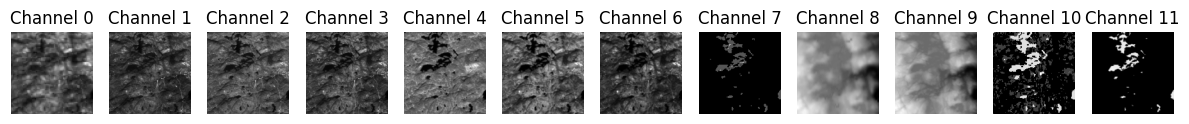

In [5]:
def visualize_image(image, title="Image"):
    """
    Visualizes a single image or a batch of images.
    Args:
        image (numpy array): The image or batch of images to visualize.
        title (str): The title of the plot.
    """
    if len(image.shape) == 4:  # batch, channels, height, width
        # Show the first image in the batch
        image = image[0]

    if len(image.shape) == 3:  # channels, height, width
        # Plot each channel separately
        fig, axes = plt.subplots(1, image.shape[0], figsize=(15, 5))
        for i, ax in enumerate(axes):
            ax.imshow(image[i], cmap='gray')
            ax.set_title(f'Channel {i}')
            ax.axis('off')
    elif len(image.shape) == 2:  # height, width
        plt.imshow(image, cmap='gray')
        plt.title(title)
        plt.axis('off')
    else:
        raise ValueError("Unsupported image shape")

    plt.show()

# Example usage
visualize_image(images[0])  # Visualize the first image in the training set


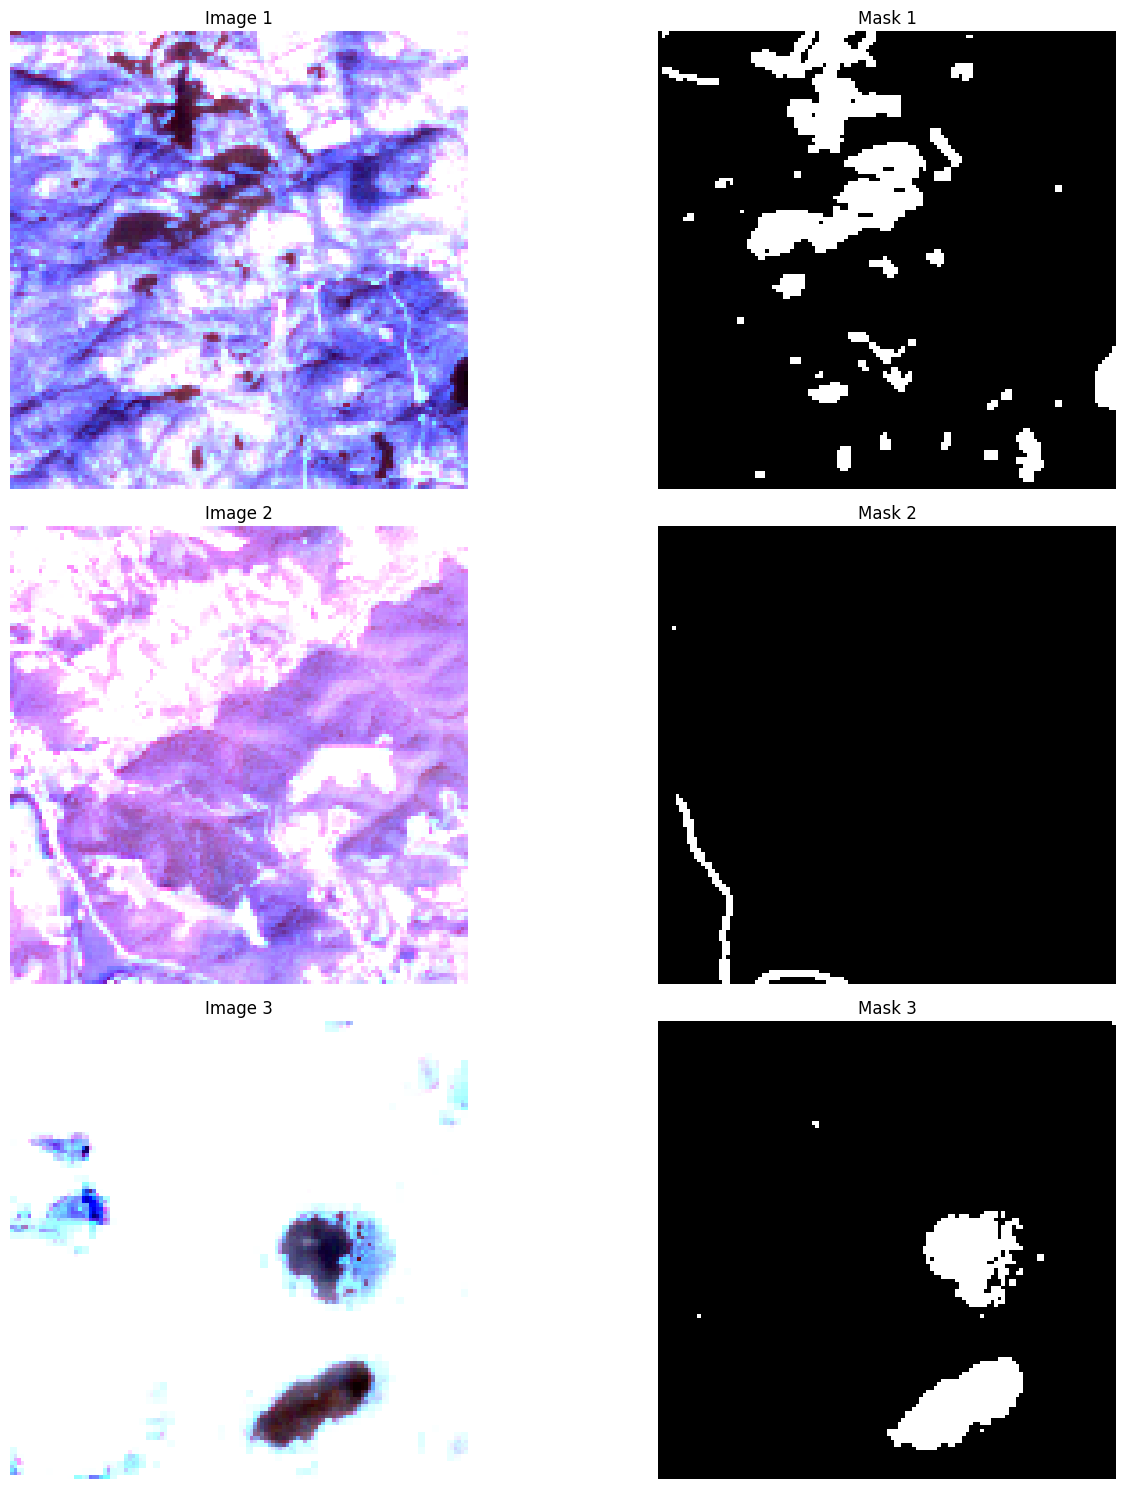

In [6]:
def visualize_images(images, masks, num_samples=3):
    plt.figure(figsize=(15, 5 * num_samples))
    for i in range(num_samples):
        # Extract RGB channels for visualization (assuming first 3 channels are RGB)
        rgb_image = np.transpose(images[i], (1, 2, 0))  # (height, width, channels)
        if rgb_image.shape[-1] >= 3:
            rgb_image = rgb_image[:, :, :3]  # Use only the first 3 channels

        plt.subplot(num_samples, 2, i * 2 + 1)
        plt.title(f'Image {i+1}')
        plt.imshow(rgb_image)
        plt.axis('off')

        plt.subplot(num_samples, 2, i * 2 + 2)
        plt.title(f'Mask {i+1}')
        plt.imshow(masks[i], cmap='gray')  # Mask is single channel
        plt.axis('off')

    plt.tight_layout()
    plt.show()

# Visualize some images and masks
visualize_images(images, masks)


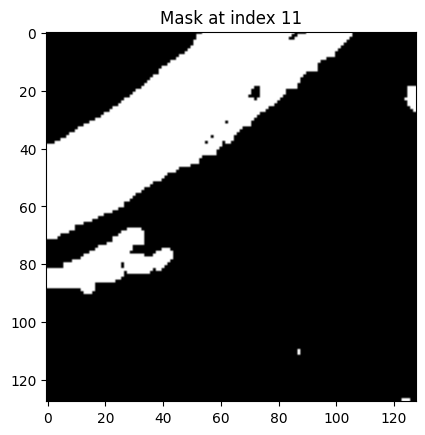

In [7]:
def visualize_mask(mask, index):
    plt.imshow(mask, cmap='gray')
    plt.title(f"Mask at index {index}")
    plt.show()

# Visualize the problematic mask
visualize_mask(masks[11], 11)


In [8]:
def normalize_image(image):
    norm_img = np.zeros_like(image, dtype=np.float32)
    for b in range(image.shape[0]):
        band = image[b]
        min_val = np.min(band)
        max_val = np.max(band)
        if max_val != min_val:
            norm_img[b] = (band - min_val) / (max_val - min_val)
        else:
            norm_img[b] = 0  # or any constant value
    return norm_img

images_normalized = np.array([normalize_image(img) for img in images])


In [9]:

X_train_val, X_test, y_train_val, y_test = train_test_split(images_normalized, masks, test_size=0.2, random_state=42)
X_train, X_val, y_train, y_val = train_test_split(X_train_val, y_train_val, test_size=0.3, random_state=42)


In [10]:
print(f"Shape of y_train: {y_train.shape}")
print(f"Type of y_train: {type(y_train)}")


Shape of y_train: (170, 128, 128)
Type of y_train: <class 'numpy.ndarray'>


In [11]:
def preprocess_images(images):
    return np.transpose(images, (0, 2, 3, 1))  # (batch_size, height, width, channels)

def preprocess_labels(labels):
    return np.expand_dims(labels, axis=-1)  # (batch_size, height, width, 1)

X_train = preprocess_images(X_train)
y_train = preprocess_labels(y_train)
X_val = preprocess_images(X_val)
y_val = preprocess_labels(y_val)
X_test = preprocess_images(X_test)
y_test = preprocess_labels(y_test)


In [12]:
print("X_train shape:", X_train.shape)
print("y_train shape:", y_train.shape)
print("X_train shape:", X_val.shape)
print("y_train shape:", y_val.shape)
print("X_test shape:", X_test.shape)
print("y_test shape:", y_test.shape)


X_train shape: (170, 128, 128, 12)
y_train shape: (170, 128, 128, 1)
X_train shape: (74, 128, 128, 12)
y_train shape: (74, 128, 128, 1)
X_test shape: (62, 128, 128, 12)
y_test shape: (62, 128, 128, 1)


## U-net Model

In [13]:
from tensorflow.keras.layers import Conv2D, MaxPooling2D, concatenate, UpSampling2D, Input
from tensorflow.keras.models import Model
from tensorflow.keras.regularizers import l2


def unet_model(input_shape, l2_lambda=0.01, spatial_dropout_rate=0.3):
    inputs = Input(input_shape)

    # Encoder
    conv1 = Conv2D(64, (3, 3), activation='relu', padding='same', kernel_regularizer=l2(l2_lambda))(inputs)
    conv1 = Conv2D(64, (3, 3), activation='relu', padding='same', kernel_regularizer=l2(l2_lambda))(conv1)
    pool1 = MaxPooling2D(pool_size=(2, 2))(conv1)

    conv2 = Conv2D(128, (3, 3), activation='relu', padding='same', kernel_regularizer=l2(l2_lambda))(pool1)
    conv2 = Conv2D(128, (3, 3), activation='relu', padding='same', kernel_regularizer=l2(l2_lambda))(conv2)
    pool2 = MaxPooling2D(pool_size=(2, 2))(conv2)

    conv3 = Conv2D(256, (3, 3), activation='relu', padding='same', kernel_regularizer=l2(l2_lambda))(pool2)
    conv3 = Conv2D(256, (3, 3), activation='relu', padding='same', kernel_regularizer=l2(l2_lambda))(conv3)
    pool3 = MaxPooling2D(pool_size=(2, 2))(conv3)

    conv4 = Conv2D(512, (3, 3), activation='relu', padding='same', kernel_regularizer=l2(l2_lambda))(pool3)
    conv4 = Conv2D(512, (3, 3), activation='relu', padding='same', kernel_regularizer=l2(l2_lambda))(conv4)
    drop4 = SpatialDropout2D(spatial_dropout_rate)(conv4)  # Spatial Dropout in Encoder
    pool4 = MaxPooling2D(pool_size=(2, 2))(drop4)

    conv5 = Conv2D(1024, (3, 3), activation='relu', padding='same', kernel_regularizer=l2(l2_lambda))(pool4)
    conv5 = Conv2D(1024, (3, 3), activation='relu', padding='same', kernel_regularizer=l2(l2_lambda))(conv5)
    drop5 = SpatialDropout2D(spatial_dropout_rate)(conv5)  # Spatial Dropout in Bottleneck

    # Decoder
    up6 = UpSampling2D(size=(2, 2))(drop5)
    merge6 = concatenate([drop4, up6], axis=3)
    conv6 = Conv2D(512, (3, 3), activation='relu', padding='same', kernel_regularizer=l2(l2_lambda))(merge6)
    conv6 = Conv2D(512, (3, 3), activation='relu', padding='same', kernel_regularizer=l2(l2_lambda))(conv6)

    up7 = UpSampling2D(size=(2, 2))(conv6)
    merge7 = concatenate([conv3, up7], axis=3)
    conv7 = Conv2D(256, (3, 3), activation='relu', padding='same', kernel_regularizer=l2(l2_lambda))(merge7)
    conv7 = Conv2D(256, (3, 3), activation='relu', padding='same', kernel_regularizer=l2(l2_lambda))(conv7)

    up8 = UpSampling2D(size=(2, 2))(conv7)
    merge8 = concatenate([conv2, up8], axis=3)
    conv8 = Conv2D(128, (3, 3), activation='relu', padding='same', kernel_regularizer=l2(l2_lambda))(merge8)
    conv8 = Conv2D(128, (3, 3), activation='relu', padding='same', kernel_regularizer=l2(l2_lambda))(conv8)

    up9 = UpSampling2D(size=(2, 2))(conv8)
    merge9 = concatenate([conv1, up9], axis=3)
    conv9 = Conv2D(64, (3, 3), activation='relu', padding='same', kernel_regularizer=l2(l2_lambda))(merge9)
    conv9 = Conv2D(64, (3, 3), activation='relu', padding='same', kernel_regularizer=l2(l2_lambda))(conv9)

    # Output layer
    conv10 = Conv2D(1, (1, 1), activation='sigmoid')(conv9)

    model = Model(inputs=inputs, outputs=conv10)

    model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
    return model

# Example usage
input_shape = (128, 128, 12)
model = unet_model(input_shape, l2_lambda=0.001, spatial_dropout_rate=0.2)  # Adjust Spatial Dropout rate as needed
model.summary()



model.summary()

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)  │ (None, 128, 128, 12)   │              0 │ -                      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d (Conv2D)           │ (None, 128, 128, 64)   │          6,976 │ input_layer[0][0]      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_1 (Conv2D)         │ (None, 128, 128, 64)   │         36,928 │ conv2d[0][0]           │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ max_pooling2d             │ (None, 64, 64, 64)     │              0 │ conv2d_1[0][0]         │
│ (MaxPooling2D)            │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_2 (Conv2D)         │ (None, 64, 64, 128)    │         73,856 │ max_pooling2d[0][0]    │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_3 (Conv2D)         │ (None, 64, 64, 128)    │        147,584 │ conv2d_2[0][0]         │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ max_pooling2d_1           │ (None, 32, 32, 128)    │              0 │ conv2d_3[0][0]         │
│ (MaxPooling2D)            │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_4 (Conv2D)         │ (None, 32, 32, 256)    │        295,168 │ max_pooling2d_1[0][0]  │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_5 (Conv2D)         │ (None, 32, 32, 256)    │        590,080 │ conv2d_4[0][0]         │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ max_pooling2d_2           │ (None, 16, 16, 256)    │              0 │ conv2d_5[0][0]         │
│ (MaxPooling2D)            │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_6 (Conv2D)         │ (None, 16, 16, 512)    │      1,180,160 │ max_pooling2d_2[0][0]  │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_7 (Conv2D)         │ (None, 16, 16, 512)    │      2,359,808 │ conv2d_6[0][0]         │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ spatial_dropout2d         │ (None, 16, 16, 512)    │              0 │ conv2d_7[0][0]         │
│ (SpatialDropout2D)        │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ max_pooling2d_3           │ (None, 8, 8, 512)      │              0 │ spatial_dropout2d[0][… │
│ (MaxPooling2D)            │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_8 (Conv2D)         │ (None, 8, 8, 1024)     │      4,719,616 │ max_pooling2d_3[0][0]  │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_9 (Conv2D)         │ (None, 8, 8, 1024)     │      9,438,208 │ conv2d_8[0][0]         │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ spatial_dropout2d_1       │ (None, 8, 8, 1024)     │              0 │ conv2d_9[0][0]         │
│ (SpatialDropout2D)   

 Total params: 31,384,129 (119.72 MB)

 Trainable params: 31,384,129 (119.72 MB)

 Non-trainable params: 0 (0.00 B)

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)  │ (None, 128, 128, 12)   │              0 │ -                      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d (Conv2D)           │ (None, 128, 128, 64)   │          6,976 │ input_layer[0][0]      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_1 (Conv2D)         │ (None, 128, 128, 64)   │         36,928 │ conv2d[0][0]           │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ max_pooling2d             │ (None, 64, 64, 64)     │              0 │ conv2d_1[0][0]         │
│ (MaxPooling2D)            │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_2 (Conv2D)         │ (None, 64, 64, 128)    │         73,856 │ max_pooling2d[0][0]    │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_3 (Conv2D)         │ (None, 64, 64, 128)    │        147,584 │ conv2d_2[0][0]         │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ max_pooling2d_1           │ (None, 32, 32, 128)    │              0 │ conv2d_3[0][0]         │
│ (MaxPooling2D)            │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_4 (Conv2D)         │ (None, 32, 32, 256)    │        295,168 │ max_pooling2d_1[0][0]  │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_5 (Conv2D)         │ (None, 32, 32, 256)    │        590,080 │ conv2d_4[0][0]         │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ max_pooling2d_2           │ (None, 16, 16, 256)    │              0 │ conv2d_5[0][0]         │
│ (MaxPooling2D)            │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_6 (Conv2D)         │ (None, 16, 16, 512)    │      1,180,160 │ max_pooling2d_2[0][0]  │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_7 (Conv2D)         │ (None, 16, 16, 512)    │      2,359,808 │ conv2d_6[0][0]         │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ spatial_dropout2d         │ (None, 16, 16, 512)    │              0 │ conv2d_7[0][0]         │
│ (SpatialDropout2D)        │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ max_pooling2d_3           │ (None, 8, 8, 512)      │              0 │ spatial_dropout2d[0][… │
│ (MaxPooling2D)            │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_8 (Conv2D)         │ (None, 8, 8, 1024)     │      4,719,616 │ max_pooling2d_3[0][0]  │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_9 (Conv2D)         │ (None, 8, 8, 1024)     │      9,438,208 │ conv2d_8[0][0]         │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ spatial_dropout2d_1       │ (None, 8, 8, 1024)     │              0 │ conv2d_9[0][0]         │
│ (SpatialDropout2D)   

 Total params: 31,384,129 (119.72 MB)

 Trainable params: 31,384,129 (119.72 MB)

 Non-trainable params: 0 (0.00 B)

In [17]:
model.compile(optimizer=Adam(learning_rate=0.0001),
              loss='binary_crossentropy',
              metrics=['accuracy'])


In [14]:
# Define callbacks
early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=3, min_lr=1e-6)

# Train the model
history = model.fit(
    X_train, y_train,
    batch_size=32,
    epochs=50,
    validation_data=(X_val, y_val),
    callbacks=[early_stopping, reduce_lr]
)


Epoch 1/50
6/6 ━━━━━━━━━━━━━━━━━━━━ 132s 14s/step - accuracy: 0.7160 - loss: 5.5734 - val_accuracy: 0.8480 - val_loss: 3.2430 - learning_rate: 0.0010
Epoch 2/50
6/6 ━━━━━━━━━━━━━━━━━━━━ 19s 439ms/step - accuracy: 0.8247 - loss: 2.8783 - val_accuracy: 0.7833 - val_loss: 1.9128 - learning_rate: 0.0010
Epoch 3/50
6/6 ━━━━━━━━━━━━━━━━━━━━ 5s 426ms/step - accuracy: 0.8534 - loss: 1.6117 - val_accuracy: 0.8760 - val_loss: 1.0963 - learning_rate: 0.0010
Epoch 4/50
6/6 ━━━━━━━━━━━━━━━━━━━━ 3s 442ms/step - accuracy: 0.8693 - loss: 1.0874 - val_accuracy: 0.9036 - val_loss: 0.8598 - learning_rate: 0.0010
Epoch 5/50
6/6 ━━━━━━━━━━━━━━━━━━━━ 3s 432ms/step - accuracy: 0.8794 - loss: 0.8570 - val_accuracy: 0.8980 - val_loss: 0.7192 - learning_rate: 0.0010
Epoch 6/50
6/6 ━━━━━━━━━━━━━━━━━━━━ 3s 432ms/step - accuracy: 0.8897 - loss: 0.7226 - val_accuracy: 0.9110 - val_loss: 0.6500 - learning_rate: 0.0010
Epoch 7/50
6/6 ━━━━━━━━━━━━━━━━━━━━ 5s 428ms/step - accuracy: 0.8856 - loss: 0.6479 - val_accuracy:

In [15]:
test_loss, test_acc = model.evaluate(X_test, y_test)
print(f"Test Loss: {test_loss}, Test Accuracy: {test_acc}")


2/2 ━━━━━━━━━━━━━━━━━━━━ 16s 15s/step - accuracy: 0.9277 - loss: 0.2590
Test Loss: 0.25718390941619873, Test Accuracy: 0.9273317456245422


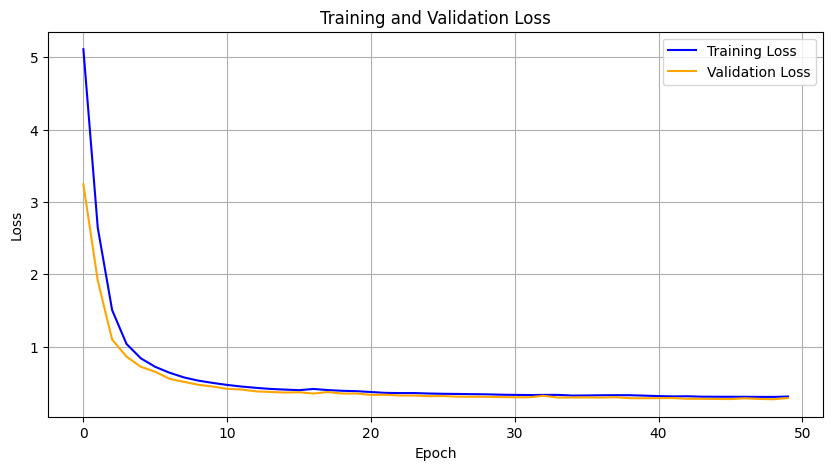

In [16]:
def plot_training_history(history):
    # Get training and validation loss from the history object
    train_loss = history.history['loss']
    val_loss = history.history.get('val_loss')  # Might be None if validation data was not provided

    # Create the plot
    plt.figure(figsize=(10, 5))
    plt.plot(train_loss, label='Training Loss', color='blue')

    if val_loss is not None:
        plt.plot(val_loss, label='Validation Loss', color='orange')

    plt.title('Training and Validation Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()
    plt.grid(True)
    plt.show()

# Assuming 'history' is the result from model.fit()
plot_training_history(history)


In [17]:
# Make predictions on the test data
y_pred = model.predict(X_test)

# If the model outputs probabilities, convert them to class labels
y_pred_binary = (y_pred > 0.5).astype(np.uint8)  # For multi-class, use argmax; for binary, use a threshold

# Flatten arrays for evaluation
y_test_flat = y_test.flatten()
y_pred_labels_flat = y_pred_binary.flatten()

# Calculate metrics
f1 = f1_score(y_test_flat, y_pred_labels_flat, average='weighted')
precision = precision_score(y_test_flat, y_pred_labels_flat, average='weighted')
recall = recall_score(y_test_flat, y_pred_labels_flat, average='weighted')
accuracy = accuracy_score(y_test_flat, y_pred_labels_flat)

print(f"F1 Score: {f1}")
print(f"Precision: {precision}")
print(f"Recall: {recall}")
print(f"Accuracy: {accuracy}")


2/2 ━━━━━━━━━━━━━━━━━━━━ 2s 1s/step
F1 Score: 0.9242536978700276
Precision: 0.9271723313435667
Recall: 0.9273317398563508
Accuracy: 0.9273317398563508


2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 155ms/step


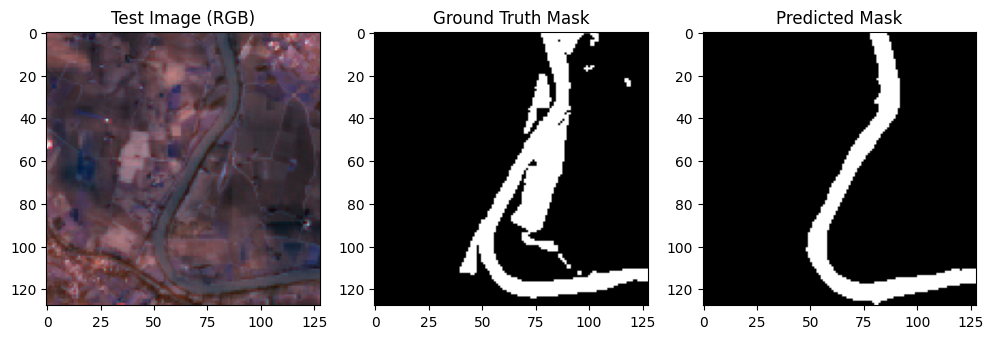

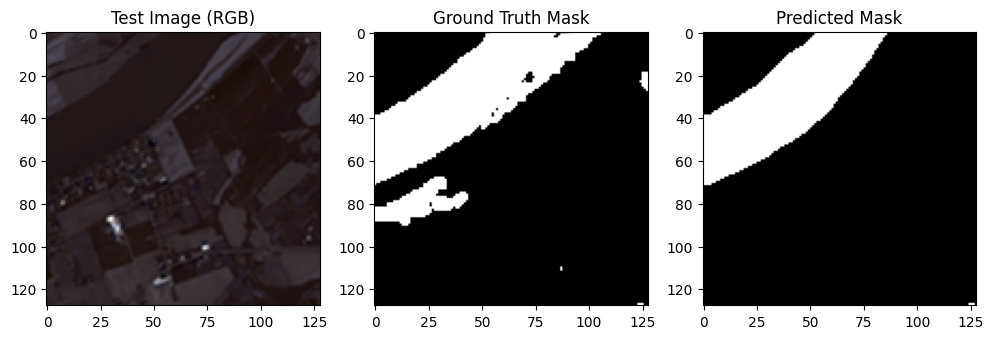

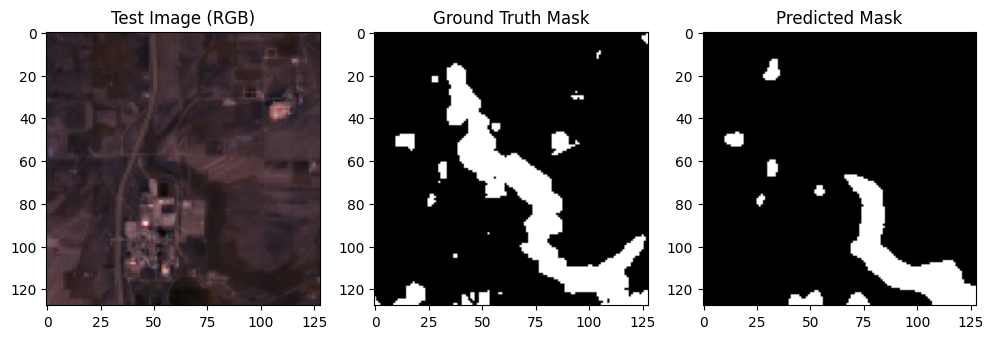

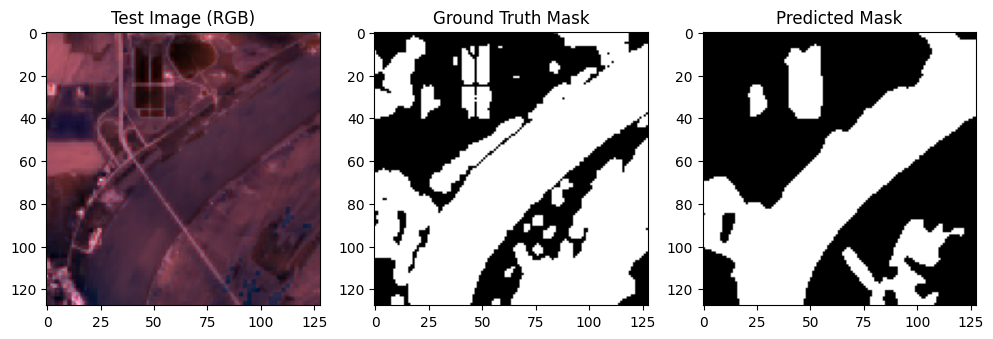

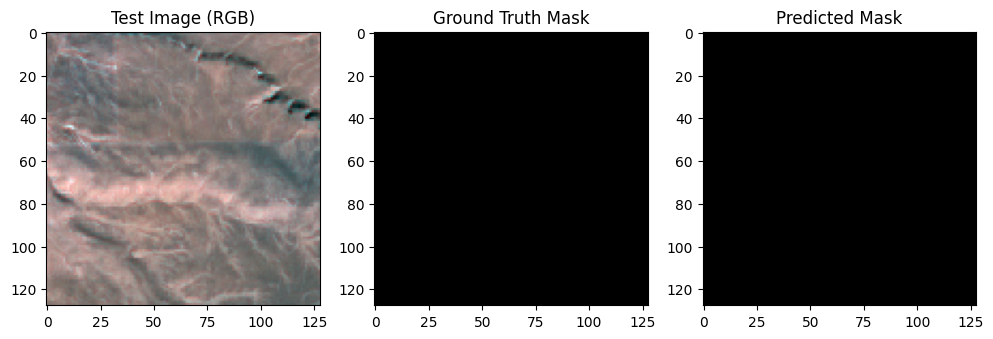

In [22]:
import matplotlib.pyplot as plt

def visualize_prediction(X_test, y_test, y_pred, index):
    """
    Visualizes the input image, ground truth mask, and predicted mask for a given index.

    Args:
    - X_test: The test images (after preprocessing).
    - y_test: The ground truth masks.
    - y_pred: The predicted masks.
    - index: The index of the sample to visualize.
    """
    # Select the test image, ground truth mask, and predicted mask at the given index
    image = X_test[index]
    true_mask = y_test[index].squeeze()  # Remove the channel dimension
    pred_mask = y_pred[index].squeeze()  # Remove the channel dimension

    # Plot the images
    plt.figure(figsize=(12, 6))

    # Display the test image (visualize only RGB channels if available)
    if image.shape[-1] >= 3:
        image_rgb = image[:, :, :3]
        plt.subplot(1, 3, 1)
        plt.imshow(image_rgb)
        plt.title("Test Image (RGB)")
    else:
        plt.subplot(1, 3, 1)
        plt.imshow(image[:, :, 0], cmap='gray')
        plt.title("Test Image (Grayscale)")

    # Display the ground truth mask
    plt.subplot(1, 3, 2)
    plt.imshow(true_mask, cmap='gray')
    plt.title("Ground Truth Mask")

    # Display the predicted mask
    plt.subplot(1, 3, 3)
    plt.imshow(pred_mask, cmap='gray')
    plt.title("Predicted Mask")

    plt.show()

# Use the trained model to make predictions
y_pred = model.predict(X_test)
y_pred = (y_pred > 0.5).astype(np.uint8)  # Binarize the predicted masks

# Visualize some samples (change the indices as needed)
for i in range(5):  # Display 3 random predictions
    visualize_prediction(X_test, y_test, y_pred, index=i)


## Using Augmentation

In [ ]:
import tensorflow as tf

def augment_image(image, mask):
    # Convert image to float32
    image = tf.cast(image, tf.float32)

    # General augmentations
    image = tf.image.random_flip_left_right(image)
    image = tf.image.random_flip_up_down(image)

    # Apply random brightness and contrast to each channel
    for c in range(image.shape[-1]):
        image = tf.image.random_brightness(image, max_delta=0.1)
        image = tf.image.random_contrast(image, lower=0.8, upper=1.2)

    return image, mask

def preprocess_image(image, mask):
    image = tf.cast(image, tf.float32)
    mask = tf.cast(mask, tf.float32)
    image = (image - tf.reduce_min(image)) / (tf.reduce_max(image) - tf.reduce_min(image))
    mask = tf.expand_dims(mask, axis=-1)  # Ensure mask has shape (height, width, 1)
    return image, mask

def create_dataset(images, masks, batch_size=32, augment=False):
    dataset = tf.data.Dataset.from_tensor_slices((images, masks))
    if augment:
        dataset = dataset.map(lambda img, lbl: augment_image(img, lbl))
    dataset = dataset.map(preprocess_image)
    dataset = dataset.shuffle(buffer_size=len(images))
    dataset = dataset.batch(batch_size)
    dataset = dataset.prefetch(buffer_size=tf.data.AUTOTUNE)
    return dataset

# Create datasets
train_dataset = create_dataset(X_train, y_train, batch_size=32, augment=True)
val_dataset = create_dataset(X_val, y_val, batch_size=32, augment=False)
test_dataset = create_dataset(X_test, y_test, batch_size=32, augment=False)


In [ ]:
import tensorflow as tf
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Conv2D, MaxPooling2D, UpSampling2D, concatenate, BatchNormalization
from tensorflow.keras.optimizers import Adam

def unet_model_2(input_size=(128, 128, 12)):
    inputs = Input(input_size)

    # Encoder
    c1 = Conv2D(64, (3, 3), activation='relu', padding='same')(inputs)
    c1 = BatchNormalization()(c1)
    c1 = Conv2D(64, (3, 3), activation='relu', padding='same')(c1)
    c1 = BatchNormalization()(c1)
    p1 = MaxPooling2D((2, 2))(c1)

    c2 = Conv2D(128, (3, 3), activation='relu', padding='same')(p1)
    c2 = BatchNormalization()(c2)
    c2 = Conv2D(128, (3, 3), activation='relu', padding='same')(c2)
    c2 = BatchNormalization()(c2)
    p2 = MaxPooling2D((2, 2))(c2)

    c3 = Conv2D(256, (3, 3), activation='relu', padding='same')(p2)
    c3 = BatchNormalization()(c3)
    c3 = Conv2D(256, (3, 3), activation='relu', padding='same')(c3)
    c3 = BatchNormalization()(c3)
    p3 = MaxPooling2D((2, 2))(c3)

    # Bottleneck
    c4 = Conv2D(512, (3, 3), activation='relu', padding='same')(p3)
    c4 = BatchNormalization()(c4)
    c4 = Conv2D(512, (3, 3), activation='relu', padding='same')(c4)
    c4 = BatchNormalization()(c4)

    # Decoder
    u5 = UpSampling2D((2, 2))(c4)
    u5 = concatenate([u5, c3])
    c5 = Conv2D(256, (3, 3), activation='relu', padding='same')(u5)
    c5 = BatchNormalization()(c5)
    c5 = Conv2D(256, (3, 3), activation='relu', padding='same')(c5)
    c5 = BatchNormalization()(c5)

    u6 = UpSampling2D((2, 2))(c5)
    u6 = concatenate([u6, c2])
    c6 = Conv2D(128, (3, 3), activation='relu', padding='same')(u6)
    c6 = BatchNormalization()(c6)
    c6 = Conv2D(128, (3, 3), activation='relu', padding='same')(c6)
    c6 = BatchNormalization()(c6)

    u7 = UpSampling2D((2, 2))(c6)
    u7 = concatenate([u7, c1])
    c7 = Conv2D(64, (3, 3), activation='relu', padding='same')(u7)
    c7 = BatchNormalization()(c7)
    c7 = Conv2D(64, (3, 3), activation='relu', padding='same')(c7)
    c7 = BatchNormalization()(c7)

    outputs = Conv2D(1, (1, 1), activation='sigmoid')(c7)

    model = Model(inputs=[inputs], outputs=[outputs])
    model.compile(optimizer=Adam(learning_rate=1e-4, clipnorm=1.0), loss='binary_crossentropy', metrics=['accuracy'])
    return model

# Instantiate the model
model = unet_model_2(input_size=(128, 128, 12))




In [ ]:
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau


# Define model input shape
input_shape = (128, 128, 12)  # Adjust according to your data
model_aug = unet_model_2(input_shape)

# Compile the model
model_aug.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=['accuracy'])


# Define callbacks
early_stopping = EarlyStopping(monitor='val_loss', patience=15, restore_best_weights=True)
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=3, min_lr=1e-6)


# Train the model
history = model_aug.fit(
    train_dataset,
    epochs=50,  # Adjust number of epochs
    steps_per_epoch=len(os.listdir(image_dir)) // 32,  # Adjust batch size
    validation_data=val_dataset,  # Define this if you have a validation dataset
    callbacks = [early_stopping ,reduce_lr]
)

# Save the model if needed
model_aug.save('/content/unet_model.h5')


Epoch 1/50
9/9 ━━━━━━━━━━━━━━━━━━━━ 26s 1s/step - accuracy: 0.4953 - loss: 0.8750 - val_accuracy: 0.7275 - val_loss: 0.6241 - learning_rate: 0.0010
Epoch 2/50
9/9 ━━━━━━━━━━━━━━━━━━━━ 6s 210ms/step - accuracy: 0.5412 - loss: 0.7182 - val_accuracy: 0.6812 - val_loss: 2.1161 - learning_rate: 0.0010
Epoch 3/50
9/9 ━━━━━━━━━━━━━━━━━━━━ 2s 208ms/step - accuracy: 0.5478 - loss: 0.7198 - val_accuracy: 0.7097 - val_loss: 1.4251 - learning_rate: 0.0010
Epoch 4/50
9/9 ━━━━━━━━━━━━━━━━━━━━ 3s 216ms/step - accuracy: 0.6008 - loss: 0.6768 - val_accuracy: 0.7281 - val_loss: 4.5982 - learning_rate: 0.0010
Epoch 5/50
9/9 ━━━━━━━━━━━━━━━━━━━━ 3s 217ms/step - accuracy: 0.6172 - loss: 0.6657 - val_accuracy: 0.7133 - val_loss: 2.9859 - learning_rate: 5.0000e-04
Epoch 6/50
9/9 ━━━━━━━━━━━━━━━━━━━━ 3s 210ms/step - accuracy: 0.6404 - loss: 0.6472 - val_accuracy: 0.7178 - val_loss: 2.0347 - learning_rate: 5.0000e-04
Epoch 7/50
9/9 ━━━━━━━━━━━━━━━━━━━━ 2s 207ms/step - accuracy: 0.6568 - loss: 0.6407 - val_accu

In [ ]:
test_loss, test_acc = model_aug.evaluate(X_test, y_test)
print(f"Test Loss: {test_loss}, Test Accuracy: {test_acc}")


2/2 ━━━━━━━━━━━━━━━━━━━━ 2s 592ms/step - accuracy: 0.6100 - loss: 0.6822
Test Loss: 0.6721025109291077, Test Accuracy: 0.6227249503135681


In [ ]:
import numpy as np
from sklearn.metrics import f1_score, precision_score, recall_score, accuracy_score

# Make predictions on the test data
y_pred = model_aug.predict(X_test)

# If the model outputs probabilities, convert them to class labels
y_pred_labels = np.argmax(y_pred, axis=-1)  # For multi-class, use argmax; for binary, use a threshold

# Flatten arrays for evaluation
y_test_flat = y_test.flatten()
y_pred_labels_flat = y_pred_labels.flatten()

# Calculate metrics
f1 = f1_score(y_test_flat, y_pred_labels_flat, average='weighted')
precision = precision_score(y_test_flat, y_pred_labels_flat, average='weighted')
recall = recall_score(y_test_flat, y_pred_labels_flat, average='weighted')
accuracy = accuracy_score(y_test_flat, y_pred_labels_flat)

print(f"F1 Score: {f1}")
print(f"Precision: {precision}")
print(f"Recall: {recall}")
print(f"Accuracy: {accuracy}")


2/2 ━━━━━━━━━━━━━━━━━━━━ 2s 1s/step


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


F1 Score: 0.48424081449092266
Precision: 0.394121391197684
Recall: 0.6277908817414315
Accuracy: 0.6277908817414315


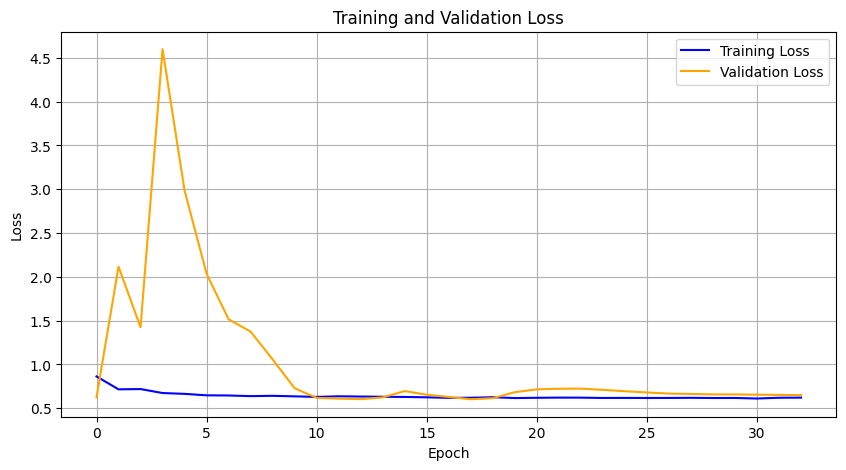

In [ ]:
import matplotlib.pyplot as plt

def plot_training_history(history):
    # Get training and validation loss from the history object
    train_loss = history.history['loss']
    val_loss = history.history.get('val_loss')  # Might be None if validation data was not provided

    # Create the plot
    plt.figure(figsize=(10, 5))
    plt.plot(train_loss, label='Training Loss', color='blue')

    if val_loss is not None:
        plt.plot(val_loss, label='Validation Loss', color='orange')

    plt.title('Training and Validation Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()
    plt.grid(True)
    plt.show()

# Assuming 'history' is the result from model.fit()
plot_training_history(history)
